Manufactured Solution experiment based on SAND2000 - 1444

Test based on heat flux example in SAND2000 - 1444 Section 3

In [1]:
%matplotlib inline

In [2]:
import fipy as fp

In [3]:
from sympy import symbols, sin, exp, sqrt, init_printing

In [4]:
from sympy import diff, simplify, Eq, lambdify

In [5]:
init_printing(use_unicode=True)

In [6]:
x, y, t = symbols('x y t')

# symbolic form

In [7]:
T0, R, t0, k0, rho0, Cp0 = symbols('T0 R t0 k0 rho0 Cp0')

In [8]:
T_sym = T0 * (1 + sin(x/R)**2 * sin(2*y/R)**2) * exp(t*(t0-t)/t0)

In [9]:
k_sym = k0 * (1 + sqrt(x**2 + 2*y**2) / R)

In [10]:
rho_sym = rho0 * (1 + sqrt(3*x**2 + y**2) / R)

In [11]:
Cp_sym = Cp0 * (1 + sqrt(2*x**2 + 3*y**2) / R)

In [12]:
g_sym = \
simplify(diff(Cp_sym * rho_sym * T_sym, t)
         - diff(k_sym * diff(T_sym, x), x) 
         - diff(k_sym * diff(T_sym, y), y))

In [13]:
g_sym

T0*(-Cp0*R*rho0*(R + sqrt(2*x**2 + 3*y**2))*(R + sqrt(3*x**2 + y**2))*(2*t - t0)*sqrt(x**2 + 2*y**2)*(sin(x/R)**2*sin(2*y/R)**2 + 1) - 2*R*k0*t0*(x*sin(2*y/R)*cos(x/R) + 4*y*sin(x/R)*cos(2*y/R))*sin(x/R)*sin(2*y/R) + 2*k0*t0*(R + sqrt(x**2 + 2*y**2))*sqrt(x**2 + 2*y**2)*(5*sin(x/R)**2*sin(2*y/R)**2 - 4*sin(x/R)**2*cos(2*y/R)**2 - sin(2*y/R)**2*cos(x/R)**2))*exp(-t*(t - t0)/t0)/(R**3*t0*sqrt(x**2 + 2*y**2))

# substitute coefficient values

In [14]:
subs = [(R, 3.33), (T0, 100), (Cp0, 1), (rho0, 0), (k0, 1), (t0, 1)]

In [15]:
g_sub, T_sub, k_sub, rho_sub, Cp_sub = [sym.subs(subs) for sym in (g_sym, T_sym, k_sym, rho_sym, Cp_sym)]

# generate FiPy lambda functions

In [16]:
g_fp, T_fp, k_fp, rho_fp, Cp_fp = [lambdify((x, y, t), sub, modules=fp.numerix) for sub in (g_sub, T_sub, k_sub, rho_sub, Cp_sub)]

# order in space

In [17]:
factor = 2.

In [18]:
grid_spacing = 1. * factor**fp.numerix.arange(0, -4, -1)

In [19]:
Terror2 = []
TerrorINF = []

In [20]:
dt = 0.1
for dx in grid_spacing:
    mesh = fp.Grid2D(Lx=10., dx=dx, Ly=20., dy=dx)
    xx, yy = mesh.cellCenters[0], mesh.cellCenters[1]
    XX, YY = mesh.faceCenters[0], mesh.faceCenters[1]

    time = fp.Variable(name="$t$", value=0.)

    T = fp.CellVariable(mesh=mesh, name="$T$", hasOld=True)
    T.value = T_fp(xx, yy, 0.)*0.01
    T.constrain(T_fp(XX, YY, time), where=mesh.exteriorFaces)
    
    eq = (fp.DiffusionTerm(coeff=k_fp(XX, YY, time)) + g_fp(xx, yy, time)
          == fp.TransientTerm(coeff=rho_fp(xx, yy, time) * Cp_fp(xx, yy, time)))
    
    while time.value <= 2.0:
        T.updateOld()
        eq.solve(var=T, dt=dt)
        time.value = time() + dt
        
    dT = T - T_fp(xx, yy, time - dt)
    
    Terror2.append(fp.numerix.L2norm(dT * mesh.cellVolumes) / fp.numerix.L2norm(mesh.cellVolumes))
    TerrorINF.append(fp.numerix.LINFnorm(dT))
    
    print dx, Terror2[-1], TerrorINF[-1]

1.0 0.50252685489 1.40546907761
0.5 0.120278992952 0.384425989971
0.25 0.029750206151 0.0991543613684
0.125 0.0074178421806 0.0251557603537


In [21]:
from matplotlib import pyplot as plt

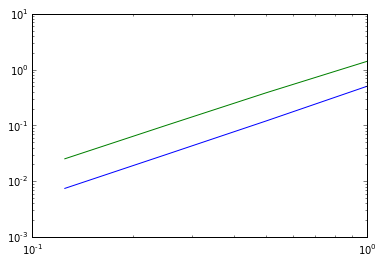

In [22]:
plt.loglog(grid_spacing, Terror2, grid_spacing, TerrorINF)

In [23]:
Terror2 = fp.numerix.array(Terror2)
TerrorINF = fp.numerix.array(TerrorINF)

In [24]:
fp.numerix.log(Terror2[:-1] / Terror2[1:]) / fp.numerix.log(factor) - 2.

array([ 0.062816  ,  0.01541312,  0.00382819])

In [25]:
fp.numerix.log(TerrorINF[:-1] / TerrorINF[1:]) / fp.numerix.log(factor) - 2.

array([-0.12972607, -0.04504226, -0.02121257])

# order in time

In [26]:
factor = 2.

In [53]:
time_step = 1. * factor**fp.numerix.arange(0, -12, -1)

In [54]:
Terror2 = []
Terror2plus = []
Terror2minus = []
TerrorINF = []

In [55]:
dx = 0.5
for dt in time_step:
    mesh = fp.Grid2D(Lx=10., dx=dx, Ly=20., dy=dx)
    xx, yy = mesh.cellCenters[0], mesh.cellCenters[1]
    XX, YY = mesh.faceCenters[0], mesh.faceCenters[1]

    time = fp.Variable(name="$t$", value=0.)

    T = fp.CellVariable(mesh=mesh, name="$T$", hasOld=True)
    T.value = T_fp(xx, yy, 0.)*0.01
    T.constrain(T_fp(XX, YY, time), where=mesh.exteriorFaces)
    
    eq = (fp.DiffusionTerm(coeff=k_fp(XX, YY, time)) + g_fp(xx, yy, time)
          == fp.TransientTerm(coeff=rho_fp(xx, yy, time) * Cp_fp(xx, yy, time)))
    
    while time.value <= 2.0:
        T.updateOld()
        time.value = time() + dt
        eq.solve(var=T, dt=dt)
        
    dT = T - T_fp(xx, yy, time)
    dTplus = T - T_fp(xx, yy, time + dt)
    dTminus = T - T_fp(xx, yy, time - dt)

    Terror2.append(fp.numerix.L2norm(dT * mesh.cellVolumes) / fp.numerix.L2norm(mesh.cellVolumes))
    Terror2plus.append(fp.numerix.L2norm(dTplus * mesh.cellVolumes) / fp.numerix.L2norm(mesh.cellVolumes))
    Terror2minus.append(fp.numerix.L2norm(dTminus * mesh.cellVolumes) / fp.numerix.L2norm(mesh.cellVolumes))
    TerrorINF.append(fp.numerix.LINFnorm(dT))
    
    print dt, Terror2[-1], TerrorINF[-1]

1.0 0.00164841471651 0.00526852961683
0.5 0.0156397224825 0.0499864160107
0.25 0.0399374302905 0.127644784759
0.125 0.0608973089516 0.194635053911
0.0625 0.0743220543026 0.237542139342
0.03125 0.0818662995118 0.261654445778
0.015625 0.0858580065104 0.274412416878
0.0078125 0.0879101658157 0.280971362491
0.00390625 0.088950494768 0.284296377757
0.001953125 0.0894742429413 0.285970339314
0.0009765625 0.0897370156085 0.286810192062
0.00048828125 0.0898686269182 0.287230837487


In [56]:
Terror2 = fp.numerix.array(Terror2)
TerrorINF = fp.numerix.array(TerrorINF)

In [57]:
fp.numerix.log(Terror2[:-1] / Terror2[1:]) / fp.numerix.log(factor)

array([ -3.24606376e+00,  -1.35252659e+00,  -6.08636969e-01,
        -2.87411902e-01,  -1.39479306e-01,  -6.86829914e-02,
        -3.40773303e-02,  -1.69726238e-02,  -8.46980158e-03,
        -4.23077321e-03,  -2.11435471e-03])

In [60]:
fp.numerix.log(TerrorINF[:-1] / TerrorINF[1:]) / fp.numerix.log(factor)

array([ -3.24606381e+00,  -1.35252660e+00,  -6.08636970e-01,
        -2.87411902e-01,  -1.39479306e-01,  -6.86829914e-02,
        -3.40773304e-02,  -1.69726238e-02,  -8.46980159e-03,
        -4.23077321e-03,  -2.11435471e-03])

In [58]:
Terror2plus = fp.numerix.array(Terror2plus)
fp.numerix.log(Terror2plus[:-1] / Terror2plus[1:]) / fp.numerix.log(factor)

array([-3.08892517, -0.79613564,  0.21351646,  0.64322413,  0.83163779,
        0.91555214,  0.94165773,  0.89891155,  0.71682973,  0.3914423 ,
        0.1343695 ])

In [59]:
Terror2minus = fp.numerix.array(Terror2minus)
fp.numerix.log(Terror2minus[:-1] / Terror2minus[1:]) / fp.numerix.log(factor)

array([ 0.24865589,  0.5705829 ,  0.78205615,  0.89115043,  0.94342183,
        0.9638149 ,  0.95563126,  0.89174251,  0.70668251,  0.40294133,
        0.15755041])